In [1]:
%load_ext autoreload
%autoreload 2

# imports
import time

# library imports
from tqdm.auto import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pacswg.timer import TimerClass

import exp_trace_utils

In [2]:
# configs
server_address = 'http://localhost:3000'

# service_name = 'tfserving-resnetv2'
# slo_timeout = 

# service_name = 'bentoml-onnx-resnet50'
# slo_timeout = 

service_name = 'bentoml-iris'
slo_timeout = 500
initial_batch_size = 5
bs_config = {
    'max_bs': 100,
    'min_bs': 1,
    'inc_step': 5,
    'dec_mult': 0.7,
}
average_timeout_ratio_threshold = 0.5

# service_name = 'tfserving-mobilenetv1'
# slo_timeout = 

# SLO Target
slo_target = slo_timeout * 0.8

# length of measurements used to estimate different batch size response times
upstream_rt_max_len = 1000

controller = exp_trace_utils.SmartProxyController(
    server_address=server_address,
    service_name=service_name,
    slo_timeout=slo_timeout,
    initial_batch_size=initial_batch_size,
    bs_config=bs_config,
    average_timeout_ratio_threshold=average_timeout_ratio_threshold,
)

# Getting and Setting Stats and Configs

In [3]:
controller.set_initial_config()

{'serviceName': 'bentoml-iris',
 'upstreamUrl': 'http://bentoml-iris.default.kn.nima-dev.com/predict',
 'maxBufferTimeoutMs': 400,
 'maxBufferSize': 5,
 'isTFServing': False}

In [4]:
proxy_stats = controller.get_proxy_stats()
proxy_stats

{'maxBufferSize': 5,
 'averageMaxBufferSize': 5,
 'averageActualBatchSize': 2.7169811320754715,
 'maxBufferTimeoutMs': 400,
 'currentReplicaCount': 1,
 'currentReadyReplicaCount': 1,
 'currentConcurrency': 0,
 'averageConcurrency': 1.2,
 'averageArrivalRate': 4.95,
 'averageDepartureRate': 5,
 'averageDispatchRate': 5,
 'averageErrorRate': 0,
 'averageTimeoutRatio': 0.8888888888888888,
 'reponseTimeAverage': 278.96527777777777,
 'reponseTimeP50': 300,
 'reponseTimeP95': 387.29999999999995,
 'batchResponseTimeStats': {'1': {'values': [22,
    22,
    23,
    23,
    25,
    27,
    27,
    29,
    29,
    29,
    30,
    32,
    34],
   'stats': {'q50': 27,
    'q95': 32.8,
    'average': 27.076923076923077,
    'count': 13},
   'batchSize': 1},
  '2': {'values': [20,
    20,
    21,
    21,
    21,
    22,
    22,
    22,
    22,
    22,
    23,
    23,
    23,
    23,
    24,
    24,
    24,
    25,
    26,
    26,
    27,
    27,
    28,
    28,
    29,
    29,
    29,
    29,
    30

In [10]:

batch_rt_values = controller.update_batch_rt_values()
# batch_rt_values

In [11]:
# run a loop to monitor response times to test the functionality
# timer = TimerClass()

# batch_rt_values = {}
# for _ in tqdm(range(1*6)):
#     timer.tic()
#     controller.update_batch_rt_values()
#     while timer.toc() < 10:
#         time.sleep(.1)

# batch_rt_values = controller.get_batch_rt_values()
# batch_rt_values

  0%|          | 0/6 [00:00<?, ?it/s]

,batch_size,average_response_time,median_response_time,p95_response_time
0,1,29.173432,29.0,38.00
1,2,31.501412,30.0,39.00
2,3,53.941341,28.0,199.65
3,4,41.117949,29.0,38.00
4,5,28.855172,28.0,44.00


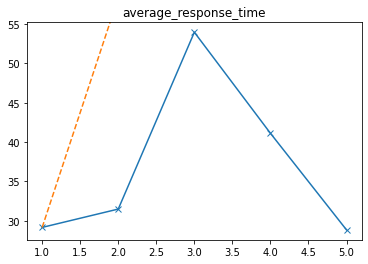

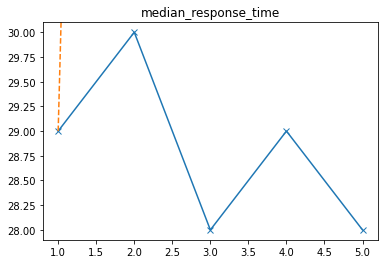

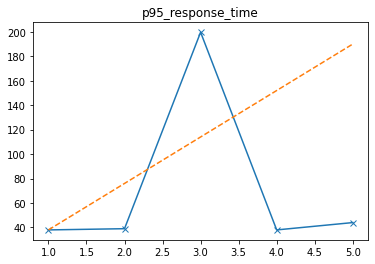

In [9]:
def analyze_batch_results(batch_rt_values):
    batch_size_results = []
    for bs, vals in batch_rt_values.items():
        # print(bs, len(vals), np.mean(vals))
        batch_size_results.append({
            'batch_size': bs,
            'average_response_time': np.mean(vals),
            'median_response_time': np.median(vals),
            'p95_response_time': np.percentile(vals,95),
        })

    df_batch_size = pd.DataFrame(data=batch_size_results)
    df_batch_size = df_batch_size.sort_values(by='batch_size')
    return df_batch_size

def plot_key_vs_batch_size(key, df_batch_size):
    plt.figure()
    plt.plot(df_batch_size['batch_size'], df_batch_size[key], marker='x')
    prev_ylim = plt.gca().get_ylim()
    # relative average response time by batch size (linear scale)
    relative_scaled_response_time = df_batch_size['batch_size']/df_batch_size['batch_size'].iloc[0]*df_batch_size[key].iloc[0]
    # plot the linear baseline
    plt.plot(df_batch_size['batch_size'], relative_scaled_response_time, ls='--')
    plt.ylim(prev_ylim)
    plt.title(key)

# df_batch_size = analyze_batch_results(batch_rt_values)
# display(df_batch_size)
# plot_key_vs_batch_size('average_response_time', df_batch_size)
# plot_key_vs_batch_size('median_response_time', df_batch_size)
# plot_key_vs_batch_size('p95_response_time', df_batch_size)

# Changing The Configuration

In [11]:
# initialize
proxy_stats = get_proxy_stats()
curr_bs = proxy_stats['maxBufferSize']

In [12]:
acc_proxy_stats = []

for _ in tqdm(range(30*2)):
    proxy_stats = get_proxy_stats()
    acc_proxy_stats.append(proxy_stats)

    # the condition for increasing or decreasing batch size
    shouldIncrease = proxy_stats['reponseTimeP95'] < slo_target
    shouldIncrease = shouldIncrease and (proxy_stats['averageTimeoutRatio'] < average_timeout_ratio_threshold)

    new_bs = calculate_new_bs(curr_bs, shouldIncrease, bs_config)

    set_proxy_config({
        'maxBufferSize': new_bs,
        'maxBufferTimeoutMs': slo_target,
    })

    print(curr_bs, new_bs)
    print(proxy_stats['averageTimeoutRatio'])
    print('------')

    # update current batch size
    curr_bs = new_bs
    time.sleep(30)

  0%|          | 0/60 [00:00<?, ?it/s]

5 3
1
------
3 8
0.46808510638297873
------
8 5
1
------
5 3
0.9230769230769231
------
3 2
0.6097560975609756
------
2 7
0.2037037037037037
------
7 4
1
------
4 2
0.631578947368421
------
2 7
0.14583333333333334
------
7 4
1
------
4 2
0.5853658536585366
------
2 7
0.18032786885245902
------
7 4
1
------
4 2
0.6222222222222222
------
2 7
0.2692307692307692
------
7 4
1
------
4 2
0.96
------
2 7
0.23529411764705882
------
7 4
1
------
4 2
0.6923076923076923
------
2 7
0.20689655172413793
------
7 4
1
------
4 2
0.8571428571428571
------
2 7
0.14035087719298245
------
7 4
0.9487179487179487
------
4 2
0.6756756756756757
------
2 7
0.17307692307692307
------
7 4
1
------
4 9
0.48717948717948717
------
9 6
1
------
6 4
0.9166666666666666
------
4 2
0.75
------
2 7
0.1746031746031746
------
7 4
1
------
4 2
0.8235294117647058
------
2 7
0.3333333333333333
------
7 4
1
------
4 2
0.8055555555555556
------
2 7
0.19672131147540983
------
7 4
1
------
4 2
0.75
------
2 7
0.19230769230769232
-

In [13]:
df_proxy_stats = pd.DataFrame(data=acc_proxy_stats)
df_proxy_stats.head()

,maxBufferSize,averageMaxBufferSize,averageActualBatchSize,maxBufferTimeoutMs,currentReplicaCount,currentReadyReplicaCount,currentConcurrency,averageConcurrency,averageArrivalRate,averageDepartureRate,averageDispatchRate,averageErrorRate,averageTimeoutRatio,reponseTimeAverage,reponseTimeP50,reponseTimeP95,batchResponseTimeStats
0,5,5,2.441441,400,1,1,0,1.3,4.45,4.45,4.45,0,1.000000,259.653137,285.0,384.0,"{'1': {'values': [21, 23, 23, 23, 25, 26, 26, ..."
1,3,3,2.404959,400,1,1,1,0.8,5.65,5.60,5.60,0,0.468085,219.216495,228.0,384.5,"{'1': {'values': [20, 22, 22, 25, 25, 27, 28, ..."
2,8,8,2.508333,400,1,1,0,1.6,5.00,4.80,4.80,0,1.000000,223.946844,240.0,383.0,"{'1': {'values': [20, 22, 22, 23, 25, 27, 28, ..."
3,5,5,2.739130,400,1,1,0,1.1,5.15,5.25,5.25,0,0.923077,257.428571,290.0,383.0,"{'1': {'values': [21, 23, 23, 24, 25, 26, 27, ..."
4,3,3,2.508065,400,1,1,1,1.0,4.30,4.30,4.30,0,0.609756,230.877814,254.0,382.0,"{'1': {'values': [21, 21, 23, 23, 24, 24, 25, ..."


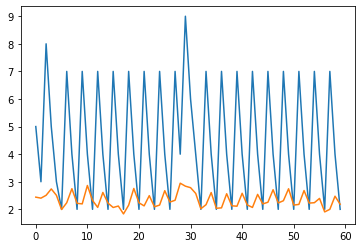

In [14]:
plt.plot(df_proxy_stats['averageMaxBufferSize'])
plt.plot(df_proxy_stats['averageActualBatchSize'])

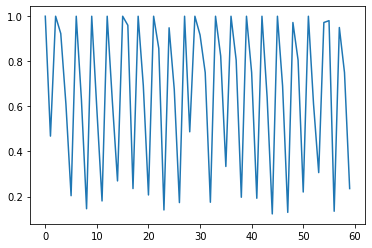

In [15]:
plt.plot(df_proxy_stats['averageTimeoutRatio'])

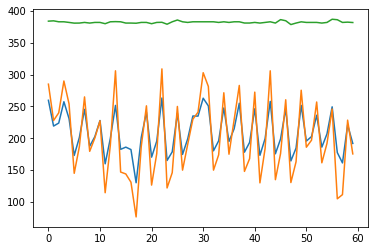

In [16]:
plt.plot(df_proxy_stats['reponseTimeAverage'])
plt.plot(df_proxy_stats['reponseTimeP50'])
plt.plot(df_proxy_stats['reponseTimeP95'])

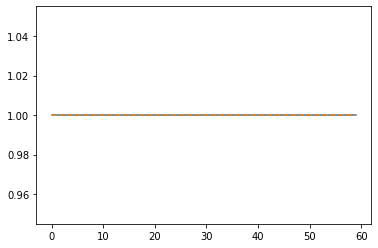

In [17]:
plt.plot(df_proxy_stats['currentReplicaCount'])
plt.plot(df_proxy_stats['currentReadyReplicaCount'], ls='--')